In [2]:

# import torch.multiprocessing as mp
from fnn.data import load_training_data
from fnn.microns.build import network
from fnn.microns import load_network_from_params
from fnn.train.schedulers import CosineLr
from fnn.train.optimizers import SgdClip
from fnn.train.loaders import Batches
from fnn.train.objectives import NetworkLoss
from fnn import microns
from fnn.utils import logging
import torch
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import polars as pl
import rerun as rr
import torchinfo


/home/kumarv4@hhmi.org/miniconda3/envs/fnn/lib/python3.13/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


ImportError: cannot import name 'nn' from 'torch' (unknown location)

In [2]:
# training data downloaded for this session
session=4
scan_idx=7

In [3]:
data_dir = f"/groups/saalfeld/saalfeldlab/vijay/fnn/training_data_27203_{session}_{scan_idx}"
max_items=32
dataset = load_training_data(data_dir, max_items)


Loading modulations:   0%|          | 0/32 [00:00<?, ?it/s]

Loading units: 100%|██████████| 32/32 [00:00<00:00, 61.12it/s]
/home/kumarv4@hhmi.org/miniconda3/envs/fnn/lib/python3.13/site-packages/fnn/data/dataset.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  assert isinstance(dataframe[item][0], Item), f"{dataframe[item][0]} is not an instance of Item"


In [4]:
# dataset is a custom object that wraps a dataframe 
dataset.df.head()

,training,samples,stimuli,perspectives,modulations,units
trial_id,,,,,,
trial0,True,300,<fnn.data.dataset.NpyFile object at 0x71a6c60d...,<fnn.data.dataset.NpyFile object at 0x71a6c60d...,<fnn.data.dataset.NpyFile object at 0x71a6c612...,<fnn.data.dataset.NpyFile object at 0x71a6c5f2...
trial1,True,300,<fnn.data.dataset.NpyFile object at 0x71a6c5f2...,<fnn.data.dataset.NpyFile object at 0x71a6c60d...,<fnn.data.dataset.NpyFile object at 0x71a6c61e...,<fnn.data.dataset.NpyFile object at 0x71a6c5f2...
trial10,True,300,<fnn.data.dataset.NpyFile object at 0x71a6c5f2...,<fnn.data.dataset.NpyFile object at 0x71a6c60d...,<fnn.data.dataset.NpyFile object at 0x71a6c61e...,<fnn.data.dataset.NpyFile object at 0x71a6c5f2...
trial100,True,300,<fnn.data.dataset.NpyFile object at 0x71a6c5f2...,<fnn.data.dataset.NpyFile object at 0x71a6c60d...,<fnn.data.dataset.NpyFile object at 0x71a6c610...,<fnn.data.dataset.NpyFile object at 0x71a6c5f2...
trial101,True,300,<fnn.data.dataset.NpyFile object at 0x71a6c5f2...,<fnn.data.dataset.NpyFile object at 0x71a6c60d...,<fnn.data.dataset.NpyFile object at 0x71a6c610...,<fnn.data.dataset.NpyFile object at 0x71a6c5f2...


# Load model

In [5]:
# Load the model and initialize weights
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

_, unit_map = microns.scan(
    session=session, 
    scan_idx=scan_idx, 
    directory="/groups/saalfeld/saalfeldlab/vijay/fnn/data/microns_digital_twin/params"
)
model = network(units=unit_map.shape[0]).to(device)
keys = model.state_dict().keys()

params = torch.load("/groups/saalfeld/saalfeldlab/vijay/fnn/data/microns_digital_twin/params/params_4_7.pt")
params.update(
    torch.load("/groups/saalfeld/saalfeldlab/vijay/fnn/data/microns_digital_twin/params/params_core.pt")
)
model.load_state_dict(params)

<All keys matched successfully>

In [6]:
# Make sure we initialized everything
assert set(keys) == set(params.keys())

In [7]:
torchinfo.summary(model.module("core"), depth=1)

Layer (type:depth-idx)                             Param #
FeedforwardRecurrent                               --
├─InputDense: 1-1                                  1,908,224
├─CvtLstm: 1-2                                     2,620,416
Total params: 4,528,640
Trainable params: 4,528,640
Non-trainable params: 0

In [8]:
torchinfo.summary(model, depth=2)

Layer (type:depth-idx)                                  Param #
Visual                                                  --
├─FeedforwardRecurrent: 1-1                             --
│    └─InputDense: 2-1                                  1,908,224
│    └─CvtLstm: 2-2                                     2,620,416
├─MlpMonitorRetina: 1-2                                 --
│    └─Plane: 2-3                                       12
│    └─StaticPower: 2-4                                 --
│    └─Angular: 2-5                                     --
│    └─SigmoidPower: 2-6                                3
│    └─Mlp: 2-7                                         678
├─MlpLstm: 1-3                                          --
│    └─Mlp: 2-8                                         192
│    └─Lstm: 2-9                                        8,704
├─PositionFeature: 1-4                                  --
│    └─Gaussian: 2-10                                   44,958
│    └─Tanh: 2-11            

# Run model

In [9]:
# Pick a stimulus
index = 10
stimuli = dataset.df.stimuli.iloc[index][:]
perspectives = dataset.df.perspectives.iloc[index][:]
modulations = dataset.df.modulations.iloc[index][:]
units = dataset.df.units.iloc[index][:]

In [10]:
# predict
pred = model.predict(stimuli, perspectives, modulations)

In [11]:
# We have 8509 units measured. But the network only predicts 7493 units. 
# We seem to only be making predictions for a subset of units & this is captured by unit_map
pred.shape, unit_map.shape, units.shape

((300, 7493), (7493, 3), (300, 8509))

In [12]:
unit_map.head()

,session,scan_idx,unit_id
readout_id,,,
0,4,7,1
1,4,7,3
2,4,7,4
3,4,7,5
4,4,7,6


In [13]:
# readout id is the index of the readout unit that the network predicts
# unit_id maps you to the experimentally measured unit
assert (unit_map.index == np.arange(unit_map.shape[0])).all()
unit_gt = units[:, unit_map["unit_id"]]

Text(0, 0.5, 'Time')

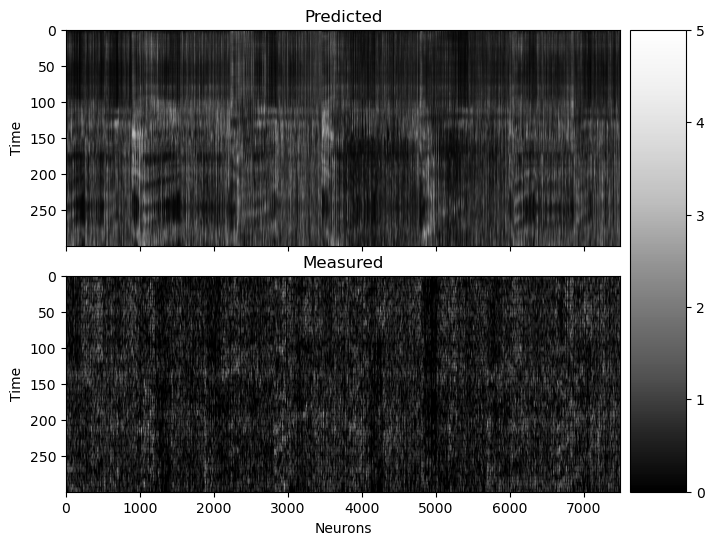

In [14]:

# Create a figure
fig = plt.figure(figsize=(8, 6))

# Create an ImageGrid with a single colorbar for the entire grid
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 1),
                 axes_pad=0.3,
                 aspect=False,
                 share_all=True,  # share x and y axes between all subplots
                 cbar_mode="single",  # use a single colorbar for the grid
                 cbar_location="right",
                 cbar_pad=0.1,
                 )
ax = grid.axes_all
ax[0].imshow(pred, aspect="auto", vmax=5, cmap="Grays_r")
ax[0].set_title("Predicted")
im = ax[1].imshow(unit_gt, aspect="auto", vmax=5, cmap="Grays_r")
ax[1].set_title("Measured")
grid.cbar_axes[0].colorbar(im)
ax[1].set_xlabel("Neurons")
ax[0].set_ylabel("Time")
ax[1].set_ylabel("Time")

Text(0, 0.5, 'Ca measurement')

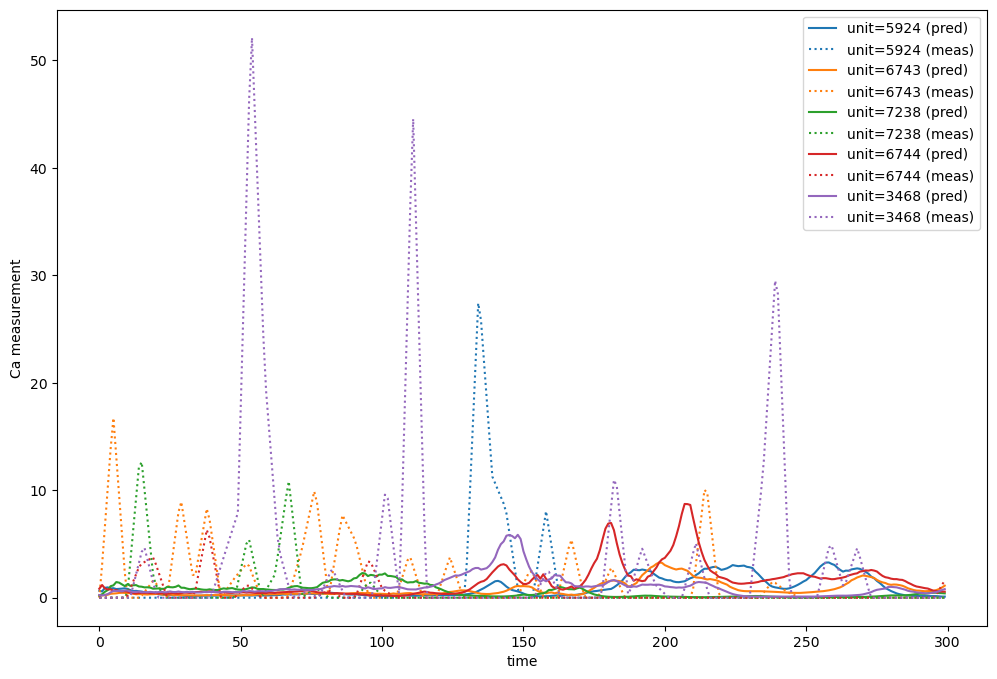

In [31]:
# 5 random neurons
# np.random.seed(0)
idxs = np.random.randint(0, 7493, size=5)
plt.figure(figsize=(12, 8))
for i in idxs:
    p = plt.plot(pred[:, i], label=f"unit={i} (pred)")
    plt.plot(unit_gt[:, i], ls="dotted", label=f"unit={i} (meas)", c = p[-1].get_color())
plt.legend(bbox_to_anchor=(1,1))
plt.xlabel("time")
plt.ylabel("Ca measurement")

In [16]:
df = pl.read_csv("/groups/saalfeld/saalfeldlab/vijay/fnn/data/microns_digital_twin/properties/anatomy/units.csv").filter(
    pl.col("session") == session
).filter(
    pl.col("scan_idx") == scan_idx
)

In [17]:
df.head()

session,scan_idx,unit_id,unit_x,unit_y,unit_z,brain_area,field
i64,i64,i64,f64,f64,f64,str,i64
4,7,1,207.46,53.12,133.37,"""LM""",1
4,7,3,294.1,46.95,133.68,"""LM""",1
4,7,4,296.3,59.25,133.32,"""LM""",1
4,7,5,283.65,56.96,133.37,"""LM""",1
4,7,6,342.1,58.6,133.41,"""LM""",1


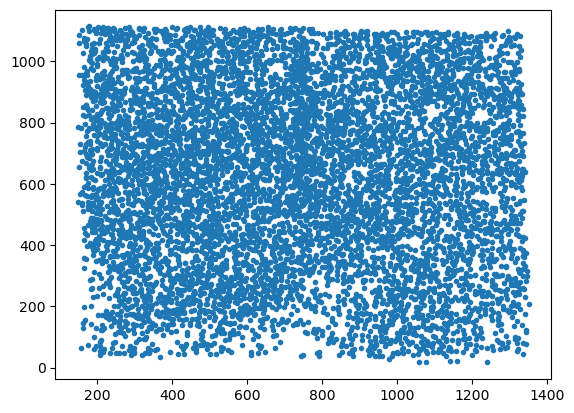

In [18]:
plt.scatter(df["unit_x"], df["unit_y"], marker=".")

In [19]:
unit_gt.shape

(300, 7493)

In [20]:
mpl.colors.to_rgba_array?

Signature: mpl.colors.to_rgba_array(c, alpha=None)
Docstring:
Convert *c* to a (n, 4) array of RGBA colors.

Parameters
----------
c : Matplotlib color or array of colors
    If *c* is a masked array, an `~numpy.ndarray` is returned with a
    (0, 0, 0, 0) row for each masked value or row in *c*.

alpha : float or sequence of floats, optional
    If *alpha* is given, force the alpha value of the returned RGBA tuple
    to *alpha*.

    If None, the alpha value from *c* is used. If *c* does not have an
    alpha channel, then alpha defaults to 1.

    *alpha* is ignored for the color value ``"none"`` (case-insensitive),
    which always maps to ``(0, 0, 0, 0)``.

    If *alpha* is a sequence and *c* is a single color, *c* will be
    repeated to match the length of *alpha*.

Returns
-------
array
    (n, 4) array of RGBA colors,  where each channel (red, green, blue,
    alpha) can assume values between 0 and 1.
File:      ~/miniconda3/envs/fnn/lib/python3.13/site-packages/matplotlib/co

In [ ]:
scaled_unit = (unit_gt/unit_gt.max()*255).astype(np.uint8)
cmap = np.array(mpl.cm.gray_r)

AttributeError: 'LinearSegmentedColormap' object has no attribute 'colors'

In [ ]:
mpl.cm.gray_r.

False

In [25]:
rr.init("plot")
rr.set_time("time", sequence=0)

try:
    for i in range(300):
        rr.set_time("time", sequence=i)
        colors = (cmap[scaled_unit[i], :]*255).astype(np.uint8)
        rr.log("/units", rr.Points3D(positions=df.select(["unit_x", "unit_y", "unit_z"]), colors=colors, radii=5))
except Exception as err:
    print("FAIL")
    print(err)
    pass
rr.notebook_show(width=1200, height=900)

HTML(value='<div id="e06b464c-e2e2-454a-b1bc-7d785ec9d09e"><style onload="eval(atob(\'KGFzeW5jIGZ1bmN0aW9uICgp…

Viewer()